In [1]:
from qutip import*
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

from tcsim.system import*
from tcsim.visualization import*


In [2]:
def char_func_grid(state, xvec):
    """Calculate the Characteristic function as a 2Dgrid (xvec, xvec) for a given state.

    Args:
        state (Qobject): State of which we want to calc the charfunc
        xvec (_type_): array of displacements. The char func will be calculated for the grid (xvec, xvec)

    Returns:
        tuple(ndarray, ndarray): Re(char func), Im(char func)
    """
    cfReal = np.empty((len(xvec),len(xvec)))
    cfImag = np.empty((len(xvec),len(xvec)))
    N = 50

    for i, alpha_x in enumerate(xvec):
        for j, alpha_p in enumerate(xvec):
            expect_value = qt.expect(qt.displace(N, alpha_x +1j*alpha_p),state)
            cfReal[i,j] =  np.real(expect_value)
            cfImag[i,j] =  np.imag(expect_value)

    return cfReal,cfImag   

In [3]:
# System
N = 50

Iq = qeye(2)
Ic = qeye(N)
a = destroy(N)
n = a.dag()*a

t1 = np.inf
gamma_a_loss = 1 / t1  # t1 = 100mu s
a_loss = np.sqrt(gamma_a_loss) * destroy(N)


vac = tensor(fock(2,0),fock(N,0))

# calculated 1D char func
def char_func_cut(state, xvec, axis = 1):
    """Calculate the Characteristic function as a 2Dgrid (xvec, xvec) for a given state.

    Args:
        state (Qobject): State of which we want to calc the charfunc
        xvec (_type_): array of displacements. The char func will be calculated for the grid (xvec, xvec)

    Returns:
        tuple(ndarray, ndarray): Re(char func), Im(char func)
    """
    cfReal = np.empty((len(xvec)))
    

    for i, alpha_x in enumerate(xvec):
            expect_value = expect(displace(N, alpha_x*axis),state)
            cfReal[i] =  np.real(expect_value)

    return cfReal

def transmission (t):
    return np.exp(-t/t1)

def relative_to_t1(t):
    return t/t1

def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

# find the min value of the wigner function, assuming the blobs are align on the X axis
def char_negativiy(state):
    xvec = np.linspace(-6,6,200)
    xcut = char_func_cut(state, xvec, 1)
    return np.min(xcut) 
 
def lossy_channel(state, t_list):
    rhos_loss = mesolve(Ic,state, t_list, c_ops = a_loss).states
    return rhos_loss

def get_data(states, t_list):
    negativity_loss=[]
    rhos_loss_stored = []
    for i in range(len(states)):
        negativity_loss.append([])
        state = states[i]
        rhos_loss = lossy_channel(state,t_list)
        rhos_loss_stored.append(rhos_loss)
        for rho in rhos_loss:
            negativity = char_negativiy(rho)
            negativity_loss[i].append(negativity) # minus sign cause i want to take a look at the positive blobs to compare it 

            
    return negativity_loss, rhos_loss_stored

In [5]:
psi = displace(N,4)*squeeze(N,calc_squeez_parameter(7))*fock(N,0)
expect(destroy(N).dag()*destroy(N),psi)

16.802848897885156

In [10]:
psi = squeeze(N,calc_squeez_parameter(7))*fock(N,0)
expect(destroy(N).dag()*destroy(N),psi)

0.8028496410830415

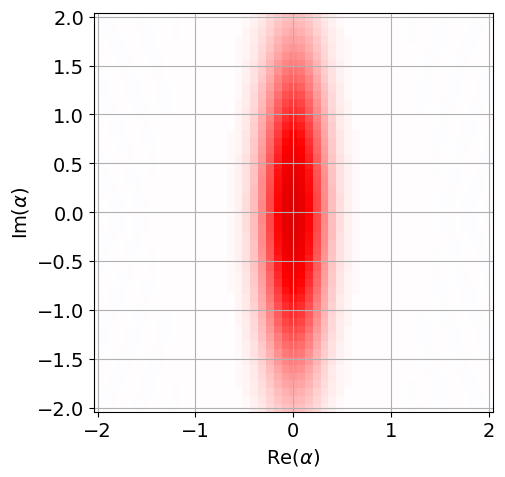

In [12]:
plot_wigner(tensor(fock(2,0),psi))

In [93]:
print(calc_squeez_parameter(6))

0.6907755278982137


In [16]:
### States
alpha = 2
cat = (coherent(N,alpha) - coherent(N,-alpha)).unit()

dBs = [0,3, 6, 9, 12]
a
# first cat, then squeeze
states = [squeeze(N,calc_squeez_parameter(i))for i in dBs]*cat

t1 = 100
gamma_a_loss = 1 / t1  # t1 = 100mu s
a_loss = np.sqrt(gamma_a_loss) * destroy(N)

In [17]:
# time evolution span
ts = np.linspace(0,70, 15) # values are chosen such that we are between transmission of 0.5 (70) and 1 (0.1)

# get the wigner negativity of the state for each point in time
negativity_loss_0, rhos = get_data(states, ts)


# use to plot the negativity vs "transmission" exp(-t/T1)
transmis = []
for i in ts:
    transmis.append(transmission(i))

# calculate points in time as fraction of T1 
rel_t1 = []
for i in ts:
    rel_t1.append(relative_to_t1(i))

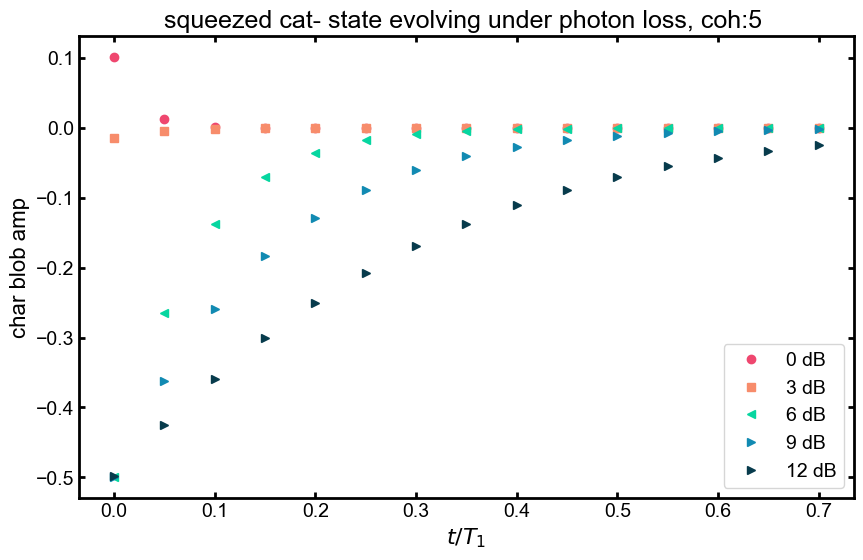

In [14]:
import matplotlib as mpl
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
#ax.grid();

#general_figure()plt.plot(transmis,negativity_loss[0], 'o', label = '0')
ax.plot(rel_t1,negativity_loss_0[0], 'o', color = '#ef476f', label = '0 dB')
ax.plot(rel_t1,negativity_loss_0[1], 's', color = '#f78c6b',label = '3 dB')
ax.plot(rel_t1,negativity_loss_0[2], '<', color = '#06d6a0',label = '6 dB')
ax.plot(rel_t1,negativity_loss_0[3], '>', color = '#118ab2',label = '9 dB')
ax.plot(rel_t1,negativity_loss_0[4], '>', color = '#073b4c',label = '12 dB')
# ax.plot(rel_t1,negativity_loss2[4], '--^', color = '#073b4c',label = '8 dB')
ax.set_xlim()

ax.set_title(f"squeezed cat- state evolving under photon loss, coh:{alpha} ", fontsize=18)
#ax.set_title(f"cat- state with different degrees of squeezing different alpha, but same state overlap under loss", fontsize=18)
ax.set_xlabel(r"$t/T_1$", fontsize=16)
ax.set_ylabel("char blob amp", fontsize=16)

ax.legend()
#plt.savefig("squeezed cat under photon loss.pdf", dpi=1200)

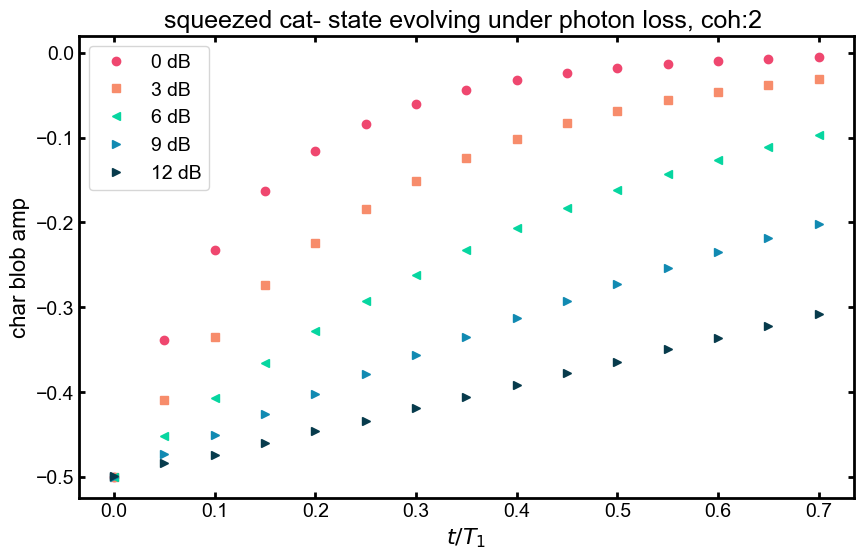

In [18]:
import matplotlib as mpl
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
#ax.grid();

#general_figure()plt.plot(transmis,negativity_loss[0], 'o', label = '0')
ax.plot(rel_t1,negativity_loss_0[0], 'o', color = '#ef476f', label = '0 dB')
ax.plot(rel_t1,negativity_loss_0[1], 's', color = '#f78c6b',label = '3 dB')
ax.plot(rel_t1,negativity_loss_0[2], '<', color = '#06d6a0',label = '6 dB')
ax.plot(rel_t1,negativity_loss_0[3], '>', color = '#118ab2',label = '9 dB')
ax.plot(rel_t1,negativity_loss_0[4], '>', color = '#073b4c',label = '12 dB')
# ax.plot(rel_t1,negativity_loss2[4], '--^', color = '#073b4c',label = '8 dB')
ax.set_xlim()

ax.set_title(f"squeezed cat- state evolving under photon loss, coh:{alpha} ", fontsize=18)
#ax.set_title(f"cat- state with different degrees of squeezing different alpha, but same state overlap under loss", fontsize=18)
ax.set_xlabel(r"$t/T_1$", fontsize=16)
ax.set_ylabel("char blob amp", fontsize=16)

ax.legend()
#plt.savefig("squeezed cat under photon loss.pdf", dpi=1200)

In [19]:
### States
dB  = 6

alphas = [1.5,2,2.5,3, 3.5]

cat = (coherent(N,alpha) - coherent(N,-alpha)).unit()
# first cat, then squeeze
states = squeeze(N,calc_squeez_parameter(dB))*[(coherent(N,alpha) - coherent(N,-alpha)).unit() for alpha in alphas]

t1 = 100
gamma_a_loss = 1 / t1  # t1 = 100mu s
a_loss = np.sqrt(gamma_a_loss) * destroy(N)

In [20]:
# time evolution span
ts = np.linspace(0,70, 15) # values are chosen such that we are between transmission of 0.5 (70) and 1 (0.1)

# get the wigner negativity of the state for each point in time
negativity_loss, rhos = get_data(states, ts)


# use to plot the negativity vs "transmission" exp(-t/T1)
transmis = []
for i in ts:
    transmis.append(transmission(i))

# calculate points in time as fraction of T1 
rel_t1 = []
for i in ts:
    rel_t1.append(relative_to_t1(i))

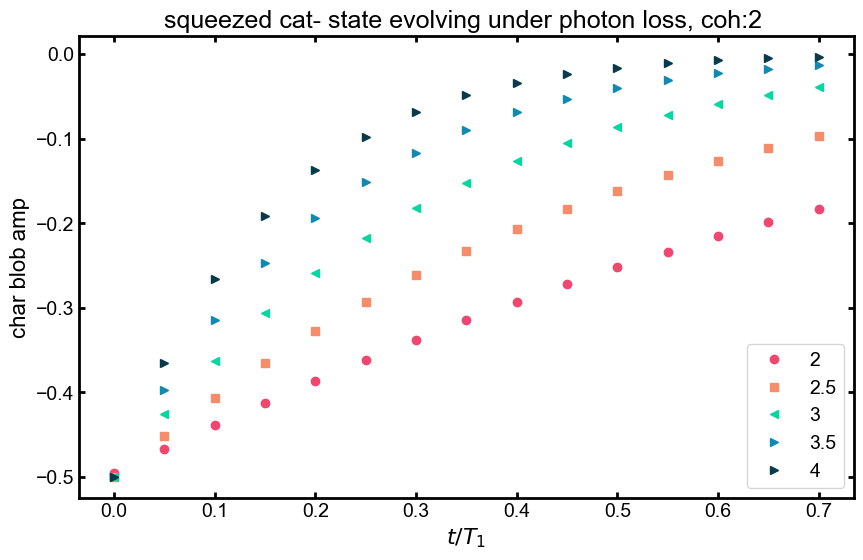

In [22]:
import matplotlib as mpl
mpl.rcParams['legend.loc'] = 'lower right'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
#ax.grid();

#general_figure()plt.plot(transmis,negativity_loss[0], 'o', label = '0')
ax.plot(rel_t1,negativity_loss[0], 'o', color = '#ef476f', label = '2')
ax.plot(rel_t1,negativity_loss[1], 's', color = '#f78c6b',label = '2.5')
ax.plot(rel_t1,negativity_loss[2], '<', color = '#06d6a0',label = '3')
ax.plot(rel_t1,negativity_loss[3], '>', color = '#118ab2',label = '3.5')
ax.plot(rel_t1,negativity_loss[4], '>', color = '#073b4c',label = '4')
# ax.plot(rel_t1,negativity_loss2[4], '--^', color = '#073b4c',label = '8 dB')
ax.set_xlim()

ax.set_title(f"squeezed cat- state evolving under photon loss, coh:{alpha} ", fontsize=18)
#ax.set_title(f"cat- state with different degrees of squeezing different alpha, but same state overlap under loss", fontsize=18)
ax.set_xlabel(r"$t/T_1$", fontsize=16)
ax.set_ylabel("char blob amp", fontsize=16)

ax.legend()
#plt.savefig("squeezed cat under photon loss.pdf", dpi=1200)

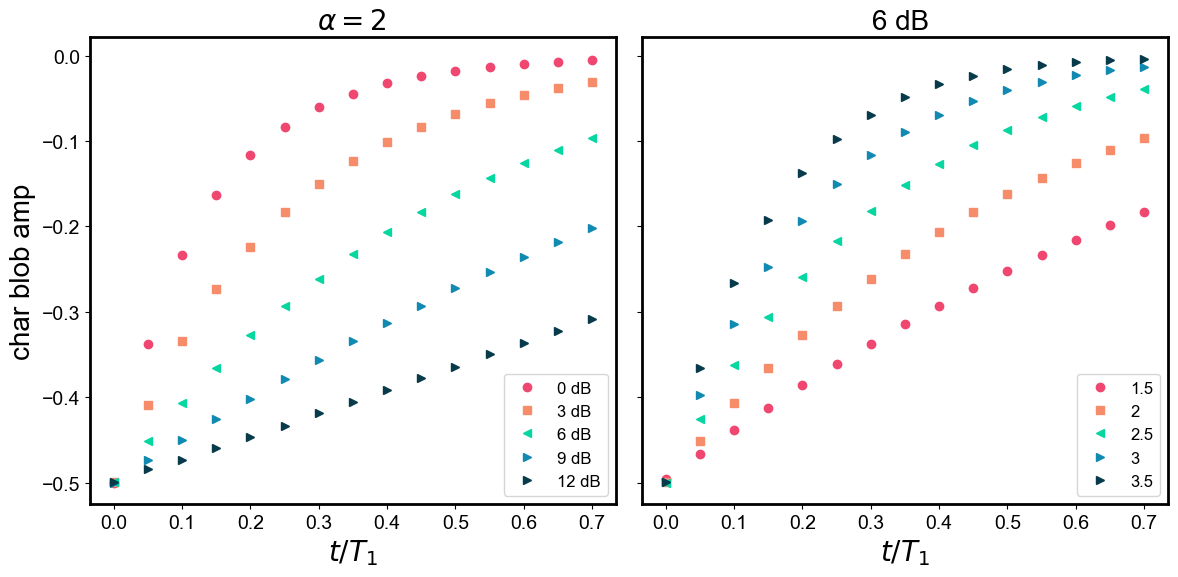

In [33]:
import matplotlib as mpl
cm = 1.0/2.54
mpl.rcParams['figure.figsize'] = [12,6]

#mpl.rcParams['figure.figsize'] = [8*cm, 4*cm]
mpl.rcParams['legend.loc'] = 'lower right'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 12

fig, ax = plt.subplots(1,2, sharey = True)

# ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
#ax.grid();
ax[0].plot(rel_t1,negativity_loss_0[0], 'o', color = '#ef476f', label = '0 dB')
ax[0].plot(rel_t1,negativity_loss_0[1], 's', color = '#f78c6b',label = '3 dB')
ax[0].plot(rel_t1,negativity_loss_0[2], '<', color = '#06d6a0',label = '6 dB')
ax[0].plot(rel_t1,negativity_loss_0[3], '>', color = '#118ab2',label = '9 dB')
ax[0].plot(rel_t1,negativity_loss_0[4], '>', color = '#073b4c',label = '12 dB')

#general_figure()plt.plot(transmis,negativity_loss[0], 'o', label = '0')
ax[1].plot(rel_t1,negativity_loss[0], 'o', color = '#ef476f', label = '1.5')
ax[1].plot(rel_t1,negativity_loss[1], 's', color = '#f78c6b',label = '2')
ax[1].plot(rel_t1,negativity_loss[2], '<', color = '#06d6a0',label = '2.5')
ax[1].plot(rel_t1,negativity_loss[3], '>', color = '#118ab2',label = '3')
ax[1].plot(rel_t1,negativity_loss[4], '>', color = '#073b4c',label = '3.5')
# ax.plot(rel_t1,negativity_loss2[4], '--^', color = '#073b4c',label = '8 dB')
ax[1].set_xlim()
ax[0].set_title(r"$\alpha = 2$ ", fontsize=20)
ax[1].set_title(f"6 dB ", fontsize=20)
#ax.set_title(f"cat- state with different degrees of squeezing different alpha, but same state overlap under loss", fontsize=18)
ax[0].set_xlabel(r"$t/T_1$", fontsize=20)
ax[1].set_xlabel(r"$t/T_1$", fontsize=20)
ax[0].set_ylabel("char blob amp", fontsize=20)
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig("squeezed_cat_under_photon_loss_2.pdf", dpi=1200)

In [10]:
x = np.linspace(-5.1, 5.1,50)
cat = char_func_grid(rhos[0][0],x)
#cat6 = char_func_grid(rhos[1][0],xvec)



In [56]:
cat_30 = char_func_grid(rhos[0][0],xvec)
cat6_40 = char_func_grid(rhos[1][0],xvec)

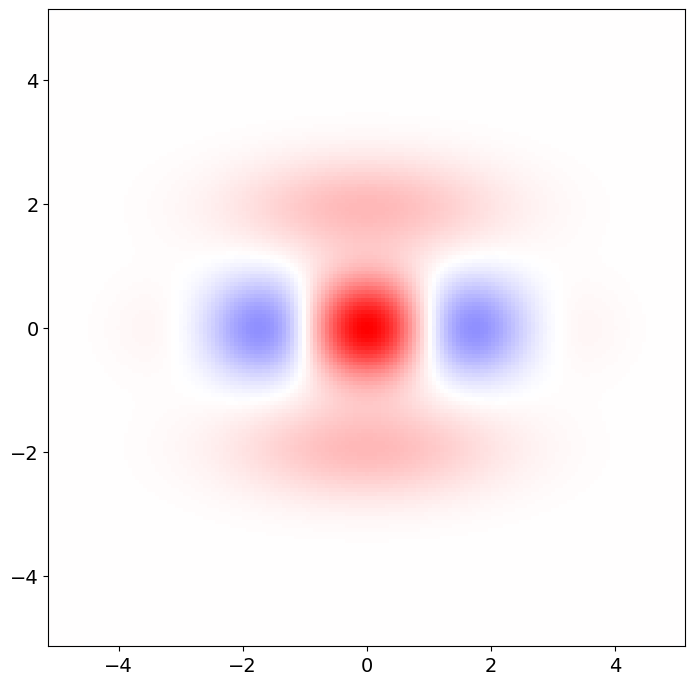

In [64]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.pcolormesh(xvec, xvec, cat6_30[0], vmin = -1, vmax = 1, cmap = "bwr")

In [ ]:
x = np.array([3,4,5])
y = np.array([6,7,8])
np.savez("my_data", my_x=x, my_y=y)

In [61]:
np.savez("cat_char_funcs", xvec = xvec, cat_0 = cat[0], cat6_0 = cat6[0], cat_30 = cat_30[0], cat6_30 = cat6_30[0] )

In [6]:
import matplotlib as mpl

cm = 1.0/2.54
mpl.rcParams['figure.figsize'] = [8*cm, 4*cm]
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['xtick.major.top'] = False
mpl.rcParams['xtick.major.bottom'] = True
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.labelleft'] = False
mpl.rcParams['ytick.direction'] = 'in'

## make figure for appendix

In [8]:
data= np.load("wigner_negativity.npz")

In [9]:
rel_t1_wig = data["rel_t1"]
negativity_loss_wig = data["negativity_loss2"]

NameError: name 'negativity_loss' is not defined

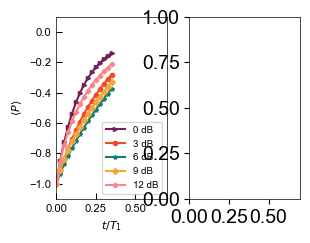

In [10]:
import matplotlib as mpl
cm = 1.0/2.54  # centimeters in inches
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams["axes.linewidth"] = 0.5
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 8

result = np.load("wigner_negativity.npz")
result['negativity_loss2']
rel_t1 = result['rel_t1']
negativity = result['negativity_loss2']

markersize = 3

fig, ax  = plt.subplots(1,2,figsize=(8*cm, 6*cm), sharex = True)
ax[0].plot(rel_t1,negativity[0], '>-',label='0 dB',color = [0.45, 0.13, 0.34], markersize=markersize   )
ax[0].plot(rel_t1,negativity[1], 'o-' , label='3 dB', color = [0.95, 0.29, 0.14], markersize=markersize )
ax[0].plot(rel_t1,negativity[2],'*-', label='6 dB', color =  [0.07, 0.49, 0.44], markersize=markersize )
ax[0].plot(rel_t1,negativity[3],'D-',label='9 dB', color =  [0.95, 0.65, 0.23], markersize=markersize )
ax[0].plot(rel_t1,negativity[4],'P-',label='12 dB', color =  [0.98, 0.52, 0.53], markersize=markersize )
ax[0].tick_params(direction = "in", bottom=True, top=False, left=True, right=False, length=4, width=0.75, labelsize = 8)

ax[0].set_ylim(-1.1,0.1)
ax[0].set_xlim(0,0.7)
ax[0].set_xlabel(r"$t/T_1$", fontsize=8)
ax[0].set_ylabel(r'$\langle P \rangle$', fontsize=8)
ax[0].legend(prop={'size': 7})


ax[1].plot(rel_t1,negativity_loss[0], '>-',label='0dB',color = [0.45, 0.13, 0.34], markersize=markersize   )
ax[1].plot(rel_t1,negativity_loss[1], 'o-' , label='3db', color = [0.95, 0.29, 0.14], markersize=markersize )
ax[1].plot(rel_t1,negativity_loss[2],'*-', label='6db', color =  [0.07, 0.49, 0.44], markersize=markersize )
ax[1].plot(rel_t1,negativity_loss[3],'D-',label='9db', color =  [0.95, 0.65, 0.23], markersize=markersize )
ax[1].plot(rel_t1,negativity_loss[4],'P-',label='12db', color =  [0.98, 0.52, 0.53], markersize=markersize )
ax[1].tick_params(direction = "in", bottom=True, top=False, left=False, right=True, length=4, width=0.75, labelsize = 8)
ax[1].set_ylabel(r'Blob amp', fontsize=8)
ax[1].set_xlabel(r"$t/T_1$", fontsize=8)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
plt.savefig('wig_char.pdf', bbox_inches='tight')

In [9]:
N

50

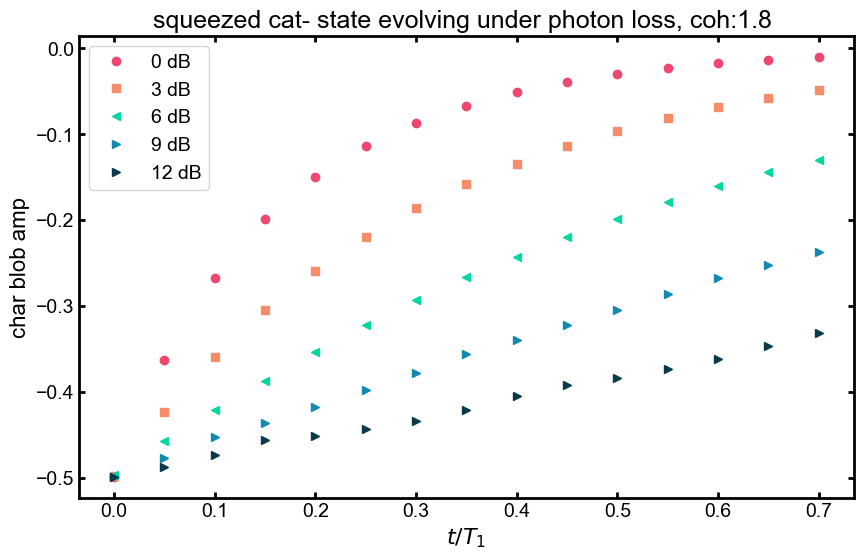

In [15]:
import matplotlib as mpl
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
#ax.grid();

#general_figure()plt.plot(transmis,negativity_loss[0], 'o', label = '0')
ax.plot(rel_t1,negativity_loss[0], 'o', color = '#ef476f', label = '0 dB')
ax.plot(rel_t1,negativity_loss[1], 's', color = '#f78c6b',label = '3 dB')
ax.plot(rel_t1,negativity_loss[2], '<', color = '#06d6a0',label = '6 dB')
ax.plot(rel_t1,negativity_loss[3], '>', color = '#118ab2',label = '9 dB')
ax.plot(rel_t1,negativity_loss[4], '>', color = '#073b4c',label = '12 dB')
# ax.plot(rel_t1,negativity_loss2[4], '--^', color = '#073b4c',label = '8 dB')
ax.set_xlim()

ax.set_title(f"squeezed cat- state evolving under photon loss, coh:{alpha} ", fontsize=18)
#ax.set_title(f"cat- state with different degrees of squeezing different alpha, but same state overlap under loss", fontsize=18)
ax.set_xlabel(r"$t/T_1$", fontsize=16)
ax.set_ylabel("char blob amp", fontsize=16)

ax.legend()
#plt.savefig("squeezed cat under photon loss.pdf", dpi=1200)

In [ ]:
plot_char(tensor(fock(2,0)*fock(2,0).dag(),rhos[0][0]), max_alpha = 5)
plot_char(tensor(fock(2,0)*fock(2,0).dag(),rhos[0][3]), max_alpha = 5)
plot_char(tensor(fock(2,0)*fock(2,0).dag(),rhos[0][14]), max_alpha = 5)

In [ ]:
plot_char(tensor(fock(2,0)*fock(2,0).dag(),rhos[2][0]), max_alpha = 5)
plot_char(tensor(fock(2,0)*fock(2,0).dag(),rhos[2][3]), max_alpha = 5)
plot_char(tensor(fock(2,0)*fock(2,0).dag(),rhos[2][14]), max_alpha = 5)

In [ ]:
plot_char(tensor(fock(2,0)*fock(2,0).dag(),rhos[4][0]), max_alpha = 5)
plot_char(tensor(fock(2,0)*fock(2,0).dag(),rhos[4][3]), max_alpha = 5)
plot_char(tensor(fock(2,0)*fock(2,0).dag(),rhos[4][14]), max_alpha = 5)

### Integrate a theoretical generated char func of the states.

In [104]:
from scipy.integrate import quad, dblquad

def char_point(x, p, rho ):
    return np.real((qt.expect(qt.displace(N, x +1j*p),rho)))

# note: i only integrate the real part, might lead to trouble later
def phase_space_integration(a,b, c, d, arg):
    result = dblquad(char_point, a, b, lambda x: c, lambda x:d, args=([arg]),epsabs=1e-03, epsrel=1e-03)
    return result[0]/(2*np.pi)


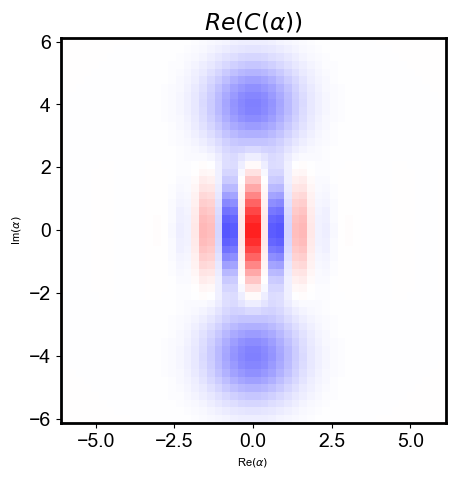

In [80]:
plot_char(tensor(fock(2,0)*fock(2,0).dag(),rhos[1][0]), max_alpha = 6)

In [105]:
cat_0dB = [phase_space_integration(-4,4, -6.5, 6.5, rho) for rho in rhos[0] ]
cat_3dB

[-0.9935620814078938,
 -0.6733624328890273,
 -0.4647444098216684,
 -0.32626744448762374,
 -0.23265089694893704,
 -0.16819027712368273,
 -0.12295868701942242,
 -0.0905712908340237,
 -0.06684758759872868,
 -0.04901057486254245,
 -0.03517727017335689,
 -0.024050236846542263,
 -0.014721002784274632,
 -0.006540580157779704,
 0.0009636772244309803]

In [112]:
cat_3dB = [phase_space_integration(-5,5, -6.5, 6.5, rho) for rho in rhos[1] ]
cat_6dB = [phase_space_integration(-6,6, -5.5, 5.5, rho) for rho in rhos[2] ]
cat_9dB = [phase_space_integration(-7,7, -4.5, 4.5, rho) for rho in rhos[3] ]


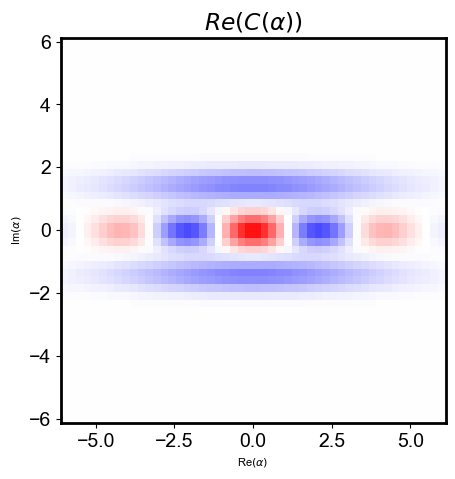

In [111]:
plot_char(tensor(fock(2,0)*fock(2,0).dag(),rhos[3][0]), max_alpha = 6)

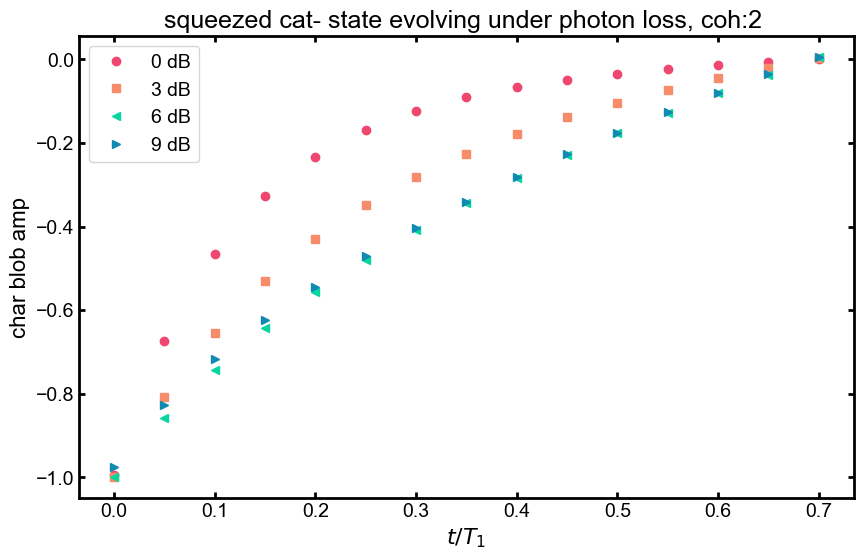

In [113]:
import matplotlib as mpl
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
#ax.grid();

#general_figure()plt.plot(transmis,negativity_loss[0], 'o', label = '0')
ax.plot(rel_t1, cat_0dB, 'o', color = '#ef476f', label = '0 dB')
ax.plot(rel_t1,cat_3dB, 's', color = '#f78c6b',label = '3 dB')
ax.plot(rel_t1,cat_6dB, '<', color = '#06d6a0',label = '6 dB')
ax.plot(rel_t1,cat_9dB, '>', color = '#118ab2',label = '9 dB')



# ax.plot(rel_t1,negativity_loss2[4], '--^', color = '#073b4c',label = '8 dB')
# ax.plot(rel_t1,negativity_loss2[5], '--v', color = '#118ab2',label = '10 dB')

ax.set_xlim()

ax.set_title(f"squeezed cat- state evolving under photon loss, coh:{alpha} ", fontsize=18)
#ax.set_title(f"cat- state with different degrees of squeezing different alpha, but same state overlap under loss", fontsize=18)
ax.set_xlabel(r"$t/T_1$", fontsize=16)
ax.set_ylabel("char blob amp", fontsize=16)

ax.legend()
plt.savefig("squeezed cat under photon loss.pdf", dpi=1200)

In [122]:
## Calculate Purity
def char_point_square(x, p, rho ):
    return (np.abs((qt.expect(qt.displace(N, x +1j*p),rho))))**2

def phase_space_integration(a,b, c, d, arg):
    result = dblquad(char_point_square, a, b, lambda x: c, lambda x:d, args=([arg]),epsabs=1e-03, epsrel=1e-03)
    return result[0]/(np.pi)


In [115]:
cat_0dB_purity = [phase_space_integration(-4,4, -6.5, 6.5, rho) for rho in rhos[0] ]
cat_3dB_purity = [phase_space_integration(-5,5, -6.5, 6.5, rho) for rho in rhos[1] ]
cat_6dB_purity = [phase_space_integration(-6,6, -5.5, 5.5, rho) for rho in rhos[2] ]
cat_9dB_purity = [phase_space_integration(-7,7, -4.5, 4.5, rho) for rho in rhos[3] ]

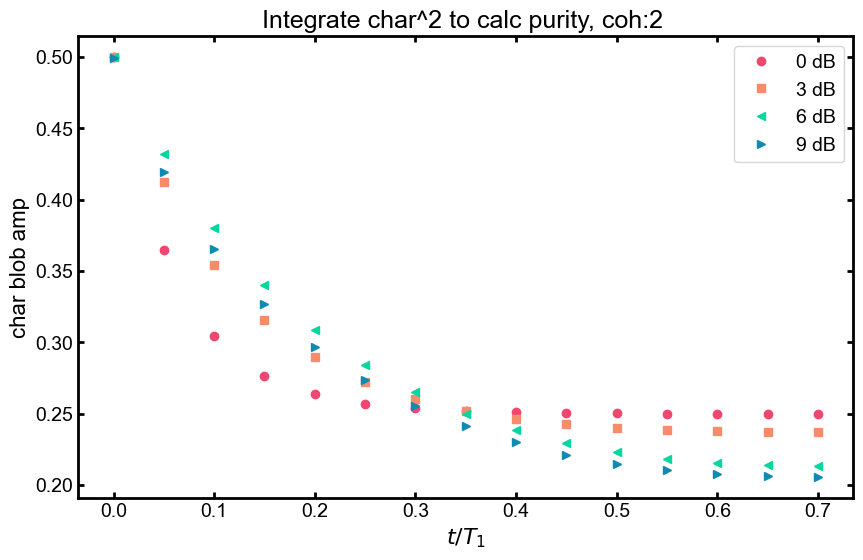

In [116]:
import matplotlib as mpl
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True

mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
#ax.grid();

#general_figure()plt.plot(transmis,negativity_loss[0], 'o', label = '0')
ax.plot(rel_t1, cat_0dB_purity, 'o', color = '#ef476f', label = '0 dB')
ax.plot(rel_t1,cat_3dB_purity, 's', color = '#f78c6b',label = '3 dB')
ax.plot(rel_t1,cat_6dB_purity, '<', color = '#06d6a0',label = '6 dB')
ax.plot(rel_t1,cat_9dB_purity, '>', color = '#118ab2',label = '9 dB')



# ax.plot(rel_t1,negativity_loss2[4], '--^', color = '#073b4c',label = '8 dB')
# ax.plot(rel_t1,negativity_loss2[5], '--v', color = '#118ab2',label = '10 dB')

ax.set_xlim()

ax.set_title(f"Integrate char^2 to calc purity, coh:{alpha} ", fontsize=18)
#ax.set_title(f"cat- state with different degrees of squeezing different alpha, but same state overlap under loss", fontsize=18)
ax.set_xlabel(r"$t/T_1$", fontsize=16)
ax.set_ylabel("char blob amp", fontsize=16)

ax.legend()
plt.savefig("state purity.pdf", dpi=1200)